In [1]:
import numpy as np
import pandas as pd
import os
from IPython.display import clear_output
import time

import sys

_lib_path = os.path.join('c:' + os.sep, 'Users', 'natha', 'OneDrive', 'Documents', 'GitHub', 'Debiasing_Kepler_Data', 'lib')

if _lib_path not in sys.path:
    sys.path.append(_lib_path)

import system_names

In [2]:
VERBOSE = True
USE_ALL_DATA = False

In [3]:
def get_index_combinations(multiplicity):
    index_combinations = []

    # Calculates each unique combination of indexes.
    for n2 in range(1, multiplicity):
        for n1 in range(0, n2):
            combination = (n1, n2)
            index_combinations.append(combination)

    return index_combinations

def generate_mutual_inclination_variation_data(savepath, system_filepaths):
    if type(system_filepaths) != list:
        raise Exception('Please input a list of system filepaths! Type of input is not a list.')

    try:
        # Open a csv file for writing to.
        csv_file = open(savepath, 'w', encoding = 'utf-8')

        # Builds the header.
        header = 'System,Planet Pair,Variation,Fractional Variation\n'

        # Writes the header to the .csv file.
        csv_file.write(header)

        # Loops through all the systems in the given filepaths.
        for system_filepath in system_filepaths:
            # Gets the system name from the end of the filepath.
            system_name = system_filepath.split(os.sep)[-1]
            
            if VERBOSE:
                seconds = time.time()
                
                if (seconds % 1.0) < 0.08:
                    clear_output()
                    print('Caching data from {system}...({pct}%)'.format(system = system_name, pct = round(((system_filepaths.index(system_filepath) + 1) / len(system_filepaths) * 100.0))))

            # Accesses the data as a pandas dataframe.
            data = pd.read_csv(system_filepath)

            # Gets the final timestep of the dataset.
            endtime = data['Time'].iloc[-1].astype(float)

            # Checks if the given file integrated to 1 Myr.
            if (not USE_ALL_DATA) and endtime < 1e6:
                continue

            # Gets the columns which contain inclination data.
            inclination_columns = sorted([column for column in data.columns if 'inclination' in column])
            Omega_columns = sorted([column for column in data.columns if 'Omega' in column])

            # Ensures the arrays are of equal length to prevent indexing errors.
            assert len(inclination_columns) == len(Omega_columns)

            # Gets the multiplicity of the system. There should be as many planets as there are unique inclination columns.
            # I.e. there is "Planet 1 inclination", "Planet 2 inclination", ... "Planet N inclination", where N is the system
            # multiplicity.
            multiplicity = len(inclination_columns)

            # Loops through every planet-planet pair combination for the given system.
            for (n1, n2) in get_index_combinations(multiplicity):                
                # Ensures that the indexes correspond to the correct columns. Makes sure the order is correct.
                assert str(n1 + 1) in inclination_columns[n1]
                assert str(n2 + 1) in inclination_columns[n2]
                
                # Captures the inclination pair data
                n1_inclinations = data[inclination_columns[n1]].astype(float)
                n2_inclinations = data[inclination_columns[n2]].astype(float)
                n1_Omegas = data[Omega_columns[n1]].astype(float)
                n2_Omegas = data[Omega_columns[n2]].astype(float)

                # Calculates the mutual inclinations.
                mutual_inclinations = np.arccos(np.cos(n1_inclinations)*np.cos(n2_inclinations)-np.sin(n1_inclinations)*np.sin(n2_inclinations)*np.cos(n1_Omegas-n2_Omegas))

                # Calculates the variations.
                min_mutual_inclination = mutual_inclinations.min()
                max_mutual_inclination = mutual_inclinations.max()
                median_mutual_inclination = mutual_inclinations.median()
                variation = max_mutual_inclination - min_mutual_inclination
                frac_variation = variation / median_mutual_inclination

                # Creates a label for the planet pair.
                planet_pair = 'Planets {planet_1} and {planet_2}'.format(planet_1 = (n1 + 1), planet_2 = (n2 + 1))

                # Appends the data to an output string.
                row = system_name + ',' + planet_pair + ',' + str(variation) + ',' + str(frac_variation) + '\n'

                # Writes the data to the .csv file.
                csv_file.write(row)

        # Closes the file.
        csv_file.close()

        # Lets the user know the data caching has completed.
        if VERBOSE:
            print('Done!')

    except FileNotFoundError as exception:
        print(exception)

In [4]:
# Creates the path to the data directory.
path = os.path.join(os.pardir, os.pardir, 'data')

# Creates a list of filepaths that link to the data files.
files = [os.path.join(path, f) for f in system_names.stable_system_names]

# Creates the savepath.
savepath = os.path.join(os.pardir, os.pardir, 'results', 'mutual_inclinations', 'variations.csv')

# Generates teh mutual inclination fractional variation data using the given savepath and list of system .csv files.
generate_mutual_inclination_variation_data(savepath, files)

Caching data from sysSim_995_randomO.csv...(100%)
Done!


In [5]:
def find_high_variations(variation, type = 'Fractional Variation'):
      df = pd.read_csv(os.path.join(os.pardir, os.pardir, 'results', 'mutual_inclinations', 'variations.csv'))

      mask = (df[type] > variation) if variation > 0 else (df[type] < variation)

      for unstable_system_name in system_names.unstable_systems:
            mask &= (df['System'] != unstable_system_name)

      return df[mask]['System']

In [8]:
find_high_variations(1.0, type = 'Variation')

734              sysSim_89.csv
735              sysSim_89.csv
736              sysSim_89.csv
737              sysSim_89.csv
738              sysSim_89.csv
3706            sysSim_389.csv
3708            sysSim_389.csv
8203    sysSim_835_randomO.csv
8205    sysSim_835_randomO.csv
8206    sysSim_835_randomO.csv
8207    sysSim_835_randomO.csv
8208    sysSim_835_randomO.csv
Name: System, dtype: object

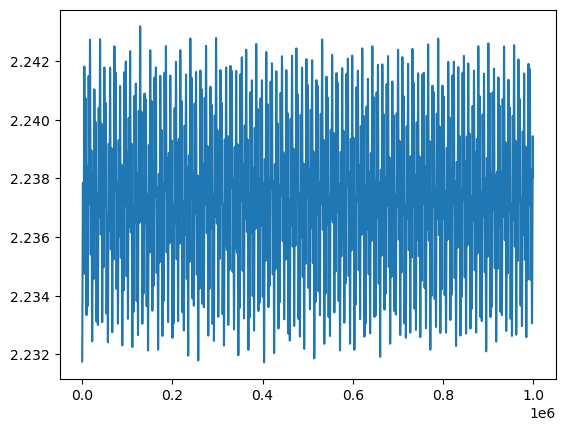

In [28]:
import matplotlib.pyplot as plt

test = pd.read_csv(os.path.join(os.pardir, os.pardir, 'data', 'sysSim_825.csv'))

plt.plot(test['Time'], test['Planet 5 inclination'])